In [1]:
# Only execute on Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install einops

    # Code to make sure output widgets display
    from google.colab import output

    output.enable_custom_widget_manager()

    !wget -q https://github.com/EffiSciencesResearch/ML4G-2.0/archive/refs/heads/master.zip
    !unzip -o /content/master.zip 'ML4G-2.0-master/workshops/Gradient_Descent/*'
    !mv --no-clobber ML4G-2.0-master/workshops/Gradient_Descent/* .
    !rm -r ML4G-2.0-master

    print("Imports & installations complete!")

else:
    from IPython import get_ipython

    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G-2.0/blob/master/workshops/Gradient_Descent/SGD_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization

In today's material focuses on understanding the standard methods of optimisation in machine learning. You're going to learn about the training loop and different optimizers.

## Gradient Descent

In the preparation work, you have seen how backpropagation works. Today, we're going to use the gradients produced by backpropagation for optimizing a loss function using gradient descent.

A loss function can be any differentiable function such that we prefer a lower value. To apply gradient descent, we start by initializing the parameters to random values (the details of this are subtle), and then repeatedly compute the gradient of the loss with respect to the model parameters. It [can be proven](https://tutorial.math.lamar.edu/Classes/CalcIII/DirectionalDeriv.aspx) that for an infinitesimal step, moving in the direction of the gradient would increase the loss by the largest amount out of all possible directions.

We actually want to decrease the loss, so we subtract the gradient to go in the opposite direction. Taking infinitesimal steps is no good, so we pick some learning rate $\lambda$ (also called the step size) and scale our step by that amount to obtain the update rule for gradient descent:

$$ \theta_t \leftarrow \theta_{t-1} - \lambda \nabla L(\theta_{t-1}) $$


## Hyperparameters

The learning rate is an example of a **hyperparameter**, which will be described below. As a reminder, a regular parameter is an adjustable value with the special and extremely convenient property that we can differentiate the loss with respect to the parameter, allowing us to efficiently learn good values for the parameter using gradient descent. In other words, the process of training is a function that takes a dataset, a model architecture, and a random seed and outputs model parameters.

The learning rate, in contrast, cannot be determined by this scheme. As a hyperparameter, we need to introduce an outer loop that wraps the training loop to search for good learning rate values. This outer loop is called a hyperparameter search, and each iteration consists of testing different combinations of hyperparameters using a dataset of pairs of $(\text{hyperparameters}, \text{validation performance})$. Obtaining results for each iteration (a single pair) requires running the inner training loop.

Due to a fixed budget of ML researcher time and available compute, we are interested in a trade-off between the ML researcher time, the cost of running the search, and the cost of training the final model. Due to the vast search space and cost of obtaining data, we don't hope to find any sort of optimum but merely to improve upon our initial guesses enough to justify the cost.

In addition, a hyperparameter isn't necessarily a single continuous value like the learning rate. Discrete unordered choices such as padding type as well as discrete ordered choices such as the number of layers in the network or the width of each convolution are all common. You will also need to choose between functions for optimizers, nonlinearities, or learning rate scheduling, of which there are an infinite number of possibilities, requiring us to select a small subset to test.

More broadly, every design decision can be considered a hyperparameter, including how to preprocess the input data, the connectivity of different layers, the types of operations, etc. Papers such as [AmeobaNet](https://arxiv.org/pdf/1801.01548.pdf) demonstrated that it's possible to find architectures superior to human-designed ones.

In the second part of today's material, you will learn about various strategies for searching over hyperparameters.

## Stochastic Gradient Descent

The terms gradient descent and SGD are used loosely in deep learning. To be technical, there are three variations:

- Batch gradient descent - the loss function is the loss over the entire dataset. This requires too much computation unless the dataset is small, so it is rarely used in deep learning.
- Stochastic gradient descent - the loss function is the loss on a randomly selected example. Any particular loss may be completely in the wrong direction of the loss on the entire dataset, but in expectation it's in the right direction. This has some nice properties but doesn't parallelize well, so it is rarely used in deep learning.
- Mini-batch gradient descent - the loss function is the loss on a batch of examples of size `batch_size`. This is the standard in deep learning.

The class `torch.SGD` can be used for any of these by varying the number of examples passed in. We will be using only mini-batch gradient descent in this course.

## Batch Size

In addition to choosing a learning rate or learning rate schedule, we need to choose the batch size or batch size schedule as well. Intuitively, using a larger batch means that the estimate of the gradient is closer to that of the true gradient over the entire dataset, but this requires more compute. Each element of the batch can be computed in parallel so with sufficient compute, one can increase the batch size without increasing wall-clock time. For small-scale experiments, a good heuristic is thus "fill up all of your GPU memory".

At a larger scale, we would expect diminishing returns of increasing the batch size, but empirically it's worse than that - a batch size that is too large generalizes more poorly in many scenarios. The intuition that a closer approximation to the true gradient is always better is therefore incorrect. See [this paper](https://arxiv.org/pdf/1706.02677.pdf) for one discussion of this.

For a batch size schedule, most commonly you'll see batch sizes increase over the course of training. The intuition is that a rough estimate of the proper direction is good enough early in training, but later in training it's important to preserve our progress and not "bounce around" too much.

You will commonly see batch sizes that are a multiple of 32. One motivation for this is that when using CUDA, threads are grouped into "warps" of 32 threads which execute the same instructions in parallel. So a batch size of 64 would allow two warps to be fully utilized, whereas a size of 65 would require waiting for a third warp to finish. As batch sizes become larger, this wastage becomes less important.

Powers of two are also common - the idea here is that work can be recursively divided up among different GPUs or within a GPU. For example, a matrix multiplication can be expressed by recursively dividing each matrix into four equal blocks and performing eight smaller matrix multiplications between the blocks.

## Computing Gradients in PyTorch

Recall that gradients are only saved for `Tensor`s for which `requires_grad=True`. For convenience, `nn.Parameter` automatically sets `requires_grad=True` on the wrapped `Tensor`. As you call `torch` functions, PyTorch tracks the relevant information needed in case you call `backward` later on, at which point it does the actual computation to compute the gradient and stores it in the `Tensor`'s `grad` field.

Also recall that PyTorch accumulates gradients across multiple `backward` calls. So if your tensor's `grad` already contains a value, after calling `backward` again it will have the sum of the original value and the new gradient. This behavior comes in handy in many situations, such as computing gradients over multiple runs on a GPU as part of a single batch. Suppose you choose a batch size of 32, but only 8 inputs fit on your GPU. A typical loss function for a batch computes the sum of losses over each example, so you can compute the losses 8 at a time and sum their gradients, producing the same result as running all 32 inputs at once.

### Stopping gradients with `torch.no_grad` or `torch.inference_mode`

You may not want PyTorch to track gradients for some computations despite involving tensors with `requires_grad=True`. In this case, you can wrap the computation in the `with torch.inference_mode()` context to prevent this tracking.


In this notebook, we will discuss the most popular optimizers used in training neural networks. You will implement optimizers from simple to compex:
- Stochastic Gradient Descent (SGD)
- SGD with Momentum
- RMSprop
- Adam

> ## Learning Objectives
> - Understand what optimizers are and why they are used
> - Get an intuition for momentum and RMS
> - Underatand what the differnet hyperparameters in Adam are and how they affect the training process


In [3]:
from typing import Iterable, Union, Optional, List, Tuple
import matplotlib.pyplot as plt
import torch as t
from SGD_tests import test_SGD, test_momentum, test_RMSprop, test_Adam, plot_rosenbrock

The job of an optimizer is to find the minimum in a Loss funciton. The loss function, we are going to consider here is Rosenbrocks Banana function.
Of cause, in practice, loss funcitons are verry high dimensional and not so simple. But we have an easier time plotting 2D functions.

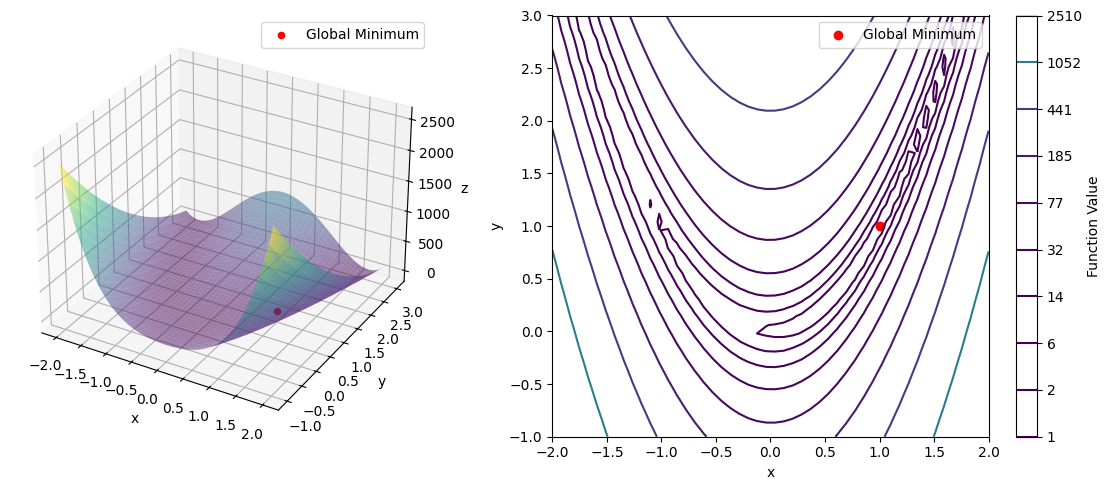

In [41]:

def rosenbrocks_banana(x: t.Tensor, y: t.Tensor, a=1, b=100) -> t.Tensor:
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1

trajectories = {}
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement the training loop and Stochastic Gradient Descent (SGD) optimizer
(2-5 mins)

The training loop consists of the following steps:
 - Compute the loss
- Compute the gradients
- Update the parameters
- zero the gradients

The update rule for Stochastic Gradient Descent (SGD) is given by:

$$\theta_{t+1} = \theta_t - \alpha \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\theta_t$ represents the model's parameters at iteration $t$.
- $\alpha$ is the learning rate, which determines the step size of the parameter updates.
- $\nabla_\theta \text{Loss}(\theta_t)$ denotes the gradient of the loss function $\text{Loss}$ with respect to the parameters $\theta_t$.

In [37]:
def optimize_function( function: callable, parameters: t.Tensor, optimizer, n_steps: int) -> List[t.Tensor]:
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        # YOUR CODE HERE
        "SOLUTION"
        loss = function(*parameters)
        print("Loss is: " + str(loss.item()))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    trajectory = t.stack(trajectory).float()
    return trajectory

class StocasticGradientDescent:
    def __init__(self, parameters: t.Tensor, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        with t.no_grad():
            # YOUR CODE HERE
            "SOLUTION"
            self.parameters -= self.learning_rate * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()

parameters = t.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.001
optimizer = StocasticGradientDescent(parameters, learning_rate)

test_SGD(StocasticGradientDescent)


SGD test passed


<details>
<summary>Solution Training loop</summary>
        

```python
def optimize_function( function: callable, parameters: t.Tensor, optimizer, n_steps: int) -> List[t.Tensor]:
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    trajectory = t.stack(trajectory).float()
    return trajectory
```

</details>

<details>
<summary>Solution SGD</summary>
        

```python
class StocasticGradientDescent:
    def __init__(self, parameters: t.Tensor, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        with t.no_grad():
            self.parameters -= self.learning_rate * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>


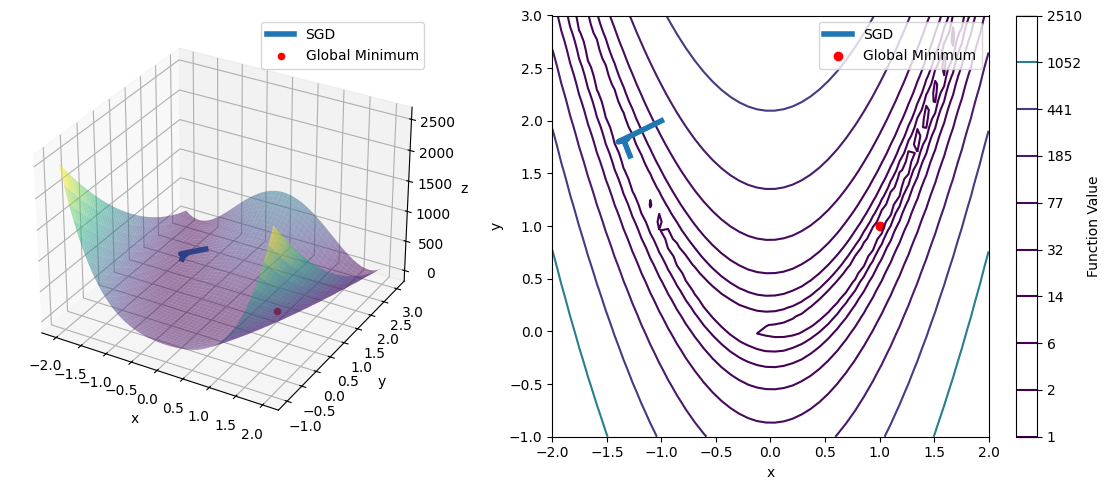

In [11]:
parameters = t.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.001
optimizer = StocasticGradientDescent(parameters, learning_rate)

trajectories["SGD"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement the training loop and Stochastic Gradient Descent with Momentum optimizer
(2-5 mins)

When we have momentum in our optimizer, we additioally keep track of the "velocity" with wich we are currently moving $m_t$. The update rule for Stochastic Gradient Descent with Momentum is given by:

$$v_{t+1} = \beta \cdot m_t + (1 - \beta) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$\theta_{t+1} = \theta_t - \alpha \cdot m_{t+1}$$

where:
- $\beta$ is the momentum parameter, which determines how much of the previous velocity we keep.
- $m_t$ represents the running average of the velocity at iteration $t$.



In [16]:
class Momentum:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float):
        self.parameters = parameters
        # YOUR CODE HERE
        "SOLUTION"
        self.learning_rate = learning_rate 
        self.beta = beta
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.average_grad = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            # YOUR CODE HERE
            "SOLUTION"
            self.average_grad = self.beta * self.average_grad + (1 - self.beta) * self.parameters.grad
            self.parameters -= self.learning_rate * self.average_grad

    def zero_grad(self):
        self.parameters.grad.zero_()

test_momentum(Momentum)


AssertionError: 

<details>
<summary>Solution Momentum</summary>
        

```python
class Momentum:
    def __init__(self, parameters: t.Tensor, learning_rate: float, momentum: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.average_grad = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.average_grad = self.momentum * self.average_grad + (1 - self.momentum) * self.parameters.grad
            self.parameters -= self.learning_rate * self.average_grad

    def zero_grad(self):
        self.parameters.grad.zero_()

```

</details>

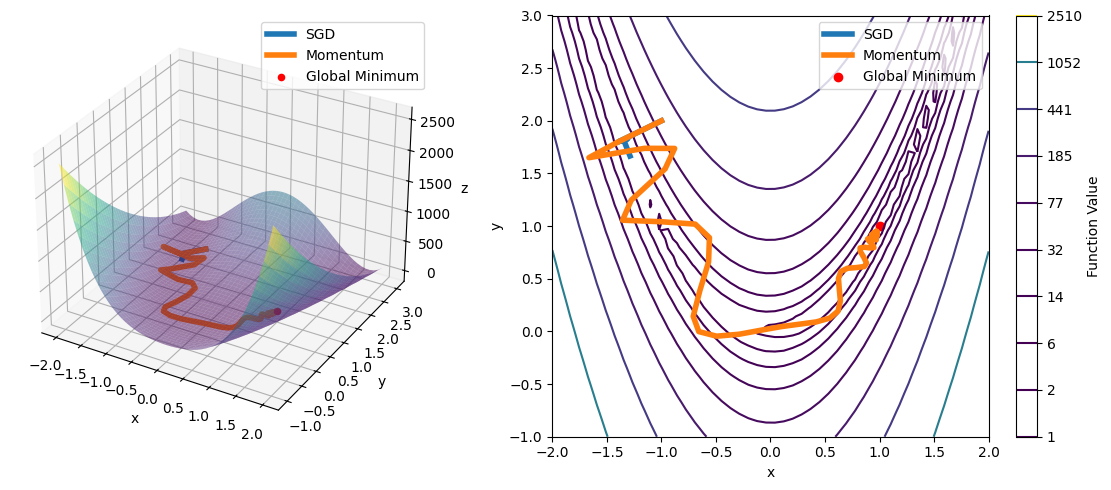

In [17]:

parameters = t.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.01
momentum = 0.9
optimizer = Momentum(parameters, learning_rate, momentum)
trajectories["Momentum"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement RMSprop optimizer
(2-5 mins)

RMSprop is an optimizer that adapts the learning rate for each parameter. To do that, we keep track of the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$r_{t+1} = \beta \cdot r_t + (1 - \beta) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{r_{t+1} + \epsilon}} \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\beta$ is the momentum parameter, which determines how much of the previous squared gradients we keep.
- $r_t$ represents the moving average of the squared gradients at iteration $t$.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.


In [21]:
class RMSProp:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float, epsilon: float):
        # YOUR CODE HERE
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.moving_avg = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            # YOUR CODE HERE
            self.moving_avg = self.beta*self.moving_avg + (1-self.beta)*self.parameters.grad**2
            self.parameters -= self.learning_rate*self.parameters.grad/(t.sqrt(self.moving_avg+self.epsilon))

    def zero_grad(self):
        self.parameters.grad.zero_()


test_RMSprop(RMSProp)

RMSprop test passed


<details>
<summary>Solution RMSprop</summary>
        

```python
class RMSprop:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.squared_gradients = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.squared_gradients = self.beta * self.squared_gradients + (1 - self.beta) * self.parameters.grad ** 2
            self.parameters -= self.learning_rate / t.sqrt(self.squared_gradients + self.epsilon) * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>

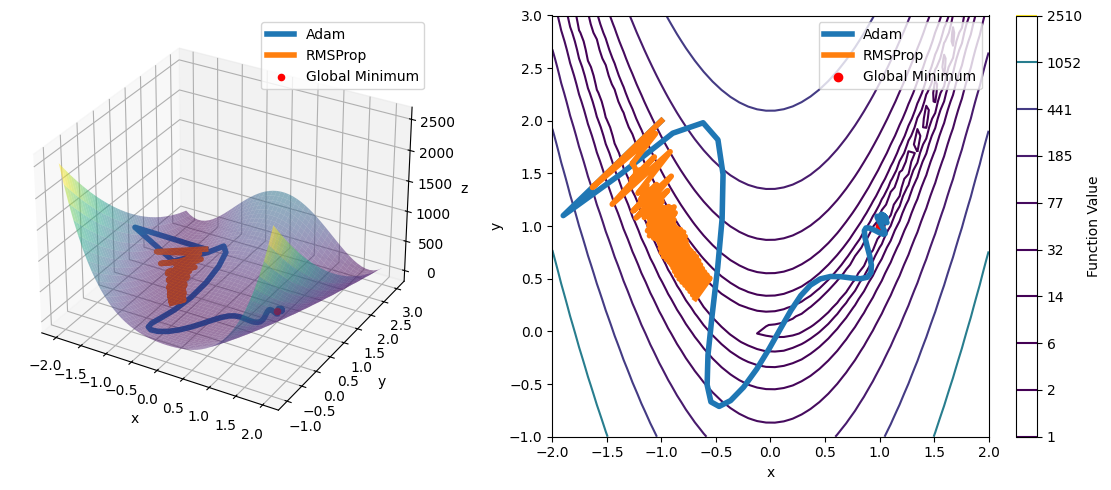

In [27]:
parameters = t.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.2
beta = 0.9
epsilon = 1e-8
optimizer = RMSProp(parameters, learning_rate, beta, epsilon)
trajectories["RMSProp"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)

plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement Adam optimizer
(2-5 mins)

For the Adam optimizer, we now bring both momentum and RMSprop together. We keep track of the moving average of the gradients $m_t$ and the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$m_{t+1} = \beta_1 \cdot m_t + (1 - \beta_1) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$r_{t+1} = \beta_2 \cdot r_t + (1 - \beta_2) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\hat{m}_{t+1} = \frac{m_{t+1}}{1 - \beta_1^{t+1}}$$
$$\hat{r}_{t+1} = \frac{r_{t+1}}{1 - \beta_2^{t+1}}$$

$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{r}_{t+1} + \epsilon}} \cdot \hat{m}_{t+1}$$

where:
- $\beta_1$ and $\beta_2$ are the momentum parameters for the gradients and squared gradients, respectively.
- $m_t$ and $r_t$ represent the moving averages of the gradients and squared gradients at iteration $t$.
- $\hat{m}_{t+1}$ and $\hat{r}_{t+1}$ are the bias-corrected moving averages.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.


In [23]:
class Adam:
    def __init__(self, parameters: t.Tensor, learning_rate: float, momentum_grad: float, momentum_grad_squared: float, epsilon: float):
        # YOUR CODE HERE
        self.t = 0
        "SOLUTION"
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum_grad = momentum_grad
        self.momentum_grad_squared = momentum_grad_squared
        self.epsilon = epsilon
        self.average_grad = t.zeros_like(parameters)
        self.average_squared_grad = t.zeros_like(parameters)
        self.t = 0
    def step(self):
        with t.no_grad():
            self.t += 1
            # YOUR CODE HERE
            "SOLUTION"
            self.average_grad = self.momentum_grad * self.average_grad + (1 - self.momentum_grad) * self.parameters.grad
            self.average_squared_grad = self.momentum_grad_squared * self.average_squared_grad + (1 - self.momentum_grad_squared) * self.parameters.grad ** 2
            average_grad_hat = self.average_grad / (1 - self.momentum_grad ** self.t)
            average_squared_grad_hat = self.average_squared_grad / (1 - self.momentum_grad_squared ** self.t)
            self.parameters -= self.learning_rate * average_grad_hat / (t.sqrt(average_squared_grad_hat) + self.epsilon)

    def zero_grad(self):
        self.parameters.grad.zero_()


test_Adam(Adam)


TypeError: Adam.__init__() got an unexpected keyword argument 'beta1'

<details>
<summary>Solution Adam</summary>
        

```python
class Adam:
    def __init__(self, parameters: t.Tensor, learning_rate: float, momentum_grad: float, momentum_grad_squared: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum_grad = momentum_grad
        self.momentum_grad_squared = momentum_grad_squared
        self.epsilon = epsilon
        self.average_grad = t.zeros_like(parameters)
        self.average_squared_grad = t.zeros_like(parameters)
        self.t = 0

    def step(self):
        with t.no_grad():
            self.t += 1
            self.average_grad = self.momentum_grad * self.average_grad + (1 - self.momentum_grad) * self.parameters.grad
            self.average_squared_grad = self.momentum_grad_squared * self.average_squared_grad + (1 - self.momentum_grad_squared) * self.parameters.grad ** 2
            average_grad_hat = self.average_grad / (1 - self.momentum_grad ** self.t)
            average_squared_grad_hat = self.average_squared_grad / (1 - self.momentum_grad_squared ** self.t)
            self.parameters -= self.learning_rate * average_grad_hat / (t.sqrt(average_squared_grad_hat) + self.epsilon)

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>


Loss is: 105.0
Loss is: 639.4201049804688
Loss is: 65.12176513671875
Loss is: 207.35792541503906
Loss is: 441.0724182128906
Loss is: 273.44189453125
Loss is: 2.3636527061462402
Loss is: 2480.565673828125
Loss is: 1796.7215576171875
Loss is: 813.3546142578125
Loss is: 73.55242156982422
Loss is: 330.6697692871094
Loss is: 645.681640625
Loss is: 145.69895935058594
Loss is: 1784.8912353515625
Loss is: 1624.7530517578125
Loss is: 999.3861083984375
Loss is: 279.2414245605469
Loss is: 72.29556274414062
Loss is: 1502.149658203125
Loss is: 2072.21923828125
Loss is: 2216.14892578125
Loss is: 2037.0198974609375
Loss is: 1589.50390625
Loss is: 948.3455200195312
Loss is: 270.6777038574219
Loss is: 113.2793960571289
Loss is: 1832.801513671875
Loss is: 1940.51708984375
Loss is: 1503.2603759765625
Loss is: 791.78466796875
Loss is: 139.44227600097656
Loss is: 219.53900146484375
Loss is: 1230.6646728515625
Loss is: 1724.8834228515625
Loss is: 1768.174072265625
Loss is: 706.9015502929688
Loss is: 116.404

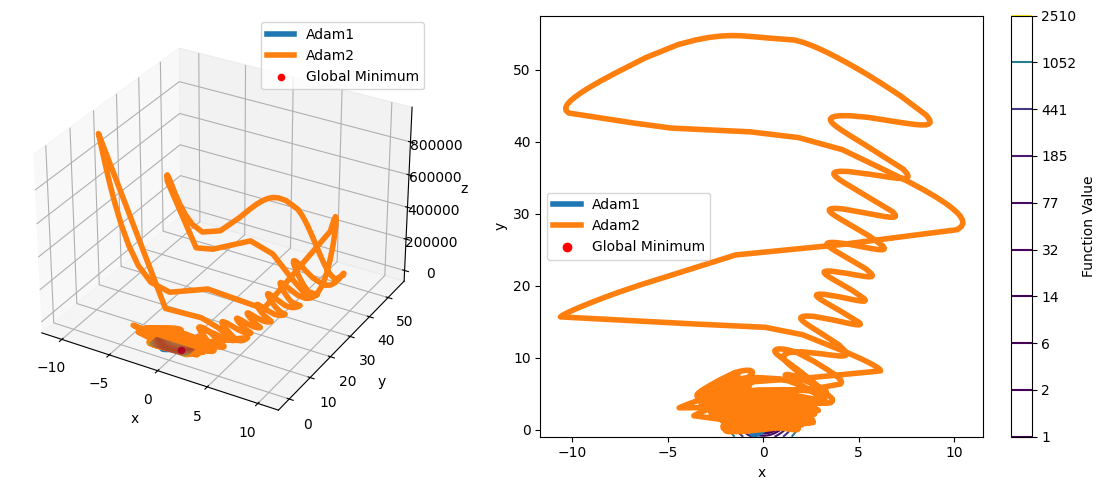

In [40]:

parameters = t.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.9
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
optimizer = Adam(parameters, learning_rate, beta1, beta2, epsilon)

trajectories["Adam2"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### BONUS Exercise - Play around with the hyperparameters

Play around with learning rates, the betas and epsilon.

Challange until time is up: get within a 1e-2 range of the minimum of the banana function in as few steps as possible.

Loss is: 105.0
Loss is: 639.4201049804688
Loss is: 20.122024536132812
Loss is: 121.2035140991211
Loss is: 259.5588073730469
Loss is: 255.24996948242188
Loss is: 172.756103515625
Loss is: 79.38037872314453
Loss is: 17.352455139160156
Loss is: 4.8636322021484375
Loss is: 33.945335388183594
Loss is: 74.84364318847656
Loss is: 96.94947052001953
Loss is: 90.36174774169922
Loss is: 65.4074935913086
Loss is: 37.40463638305664
Loss is: 16.156763076782227
Loss is: 4.71140718460083
Loss is: 1.8602118492126465
Loss is: 4.372716903686523
Loss is: 8.42359733581543
Loss is: 10.752829551696777
Loss is: 9.722249984741211
Loss is: 5.961521148681641
Loss is: 2.114325523376465
Loss is: 1.265731692314148
Loss is: 4.338024139404297
Loss is: 8.506050109863281
Loss is: 9.449309349060059
Loss is: 6.157736778259277
Loss is: 2.1299524307250977
Loss is: 1.1212100982666016
Loss is: 3.2468998432159424
Loss is: 5.630903244018555
Loss is: 5.6790900230407715
Loss is: 3.426888942718506
Loss is: 1.2692490816116333
Loss

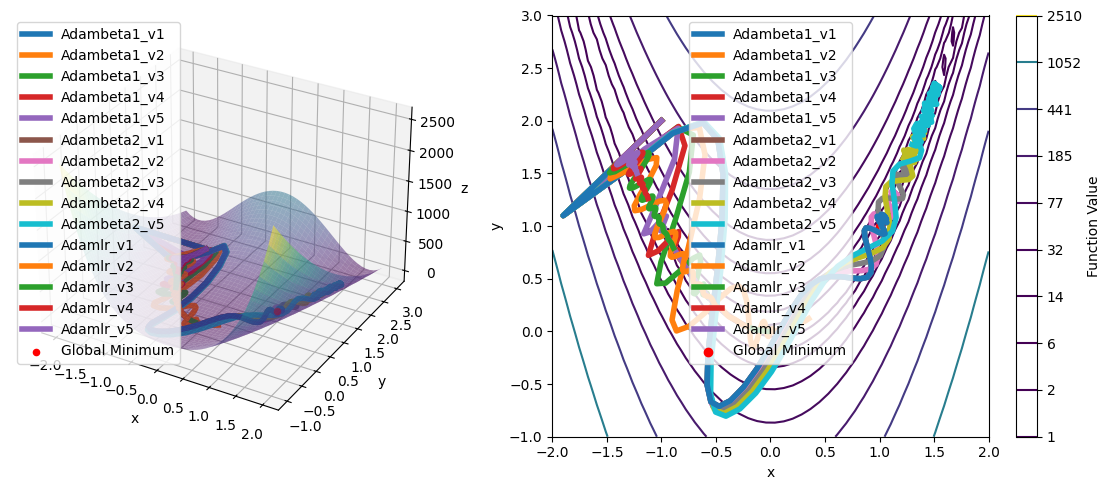

In [43]:
import torch as t

# Initial parameters for Rosenbrock's banana function
parameters_initial = t.tensor([-1.0, 2.0], requires_grad=True)

# Setting the base parameters for the optimizer
N_steps = 100
epsilon = 1e-8

# Original optimizer parameters, which we'll vary
base_learning_rate = 0.9
base_beta1 = 0.9
base_beta2 = 0.999

# Dictionary to store trajectories
trajectories = {}

# Varying beta1
for i in range(5):
    beta1_variation = base_beta1 - 0.1 * i  # Example variation
    parameters = parameters_initial.clone().detach().requires_grad_(True)
    optimizer = Adam(parameters, base_learning_rate, beta1_variation, base_beta2, epsilon)
    trajectories[f"Adambeta1_v{i+1}"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)

# Varying beta2
for i in range(5):
    beta2_variation = base_beta2 - 0.02 * i  # Example variation
    parameters = parameters_initial.clone().detach().requires_grad_(True)
    optimizer = Adam(parameters, base_learning_rate, base_beta1, beta2_variation, epsilon)
    trajectories[f"Adambeta2_v{i+1}"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)

# Varying learning_rate
for i in range(5):
    learning_rate_variation = base_learning_rate * (0.5 ** i)  # Example variation
    parameters = parameters_initial.clone().detach().requires_grad_(True)
    optimizer = Adam(parameters, learning_rate_variation, base_beta1, base_beta2, epsilon)
    trajectories[f"Adamlr_v{i+1}"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)

# Assuming plot_rosenbrock is a function that takes a dictionary of trajectories
plot_rosenbrock(trajectories)
plt.show()


# OUTCOMES
* People never play with beta1 and beta2
* People (teacher) do play around with the learning rate while looking at the loss function to see if it increases/decreases
* There is something called scheduled (not sure what it is but some people use it)

#TODO: they also talked about L2 regularization and weight decay (and how they are kind the same)...I did not really get the theory so check this by myself

The goal seems to be getting rid of parameters (weights) that are not doing anything
